# WASP RL - Meeting 2 - Lab assignment on NAF  and SQL

In this lab we implement and experiment with NAF and SQL, both algorithms we learned about in the course and both can deal with continuous state **and** action spaces. Both algorithms employ deep neural networks for function approximation. To do this assignment, you will need to work with PyTorch, a popular framework for developing neural networks. When forming groups, make sure that at least one group member if comfortable with PyTorch and its most common tensor operations.

This notebook has been created specifically for this course and this session by *Finn Rietz* and *Johannes A. Stork*, we hope you enjoy the lab :)

In [ ]:
# install requirements if needed
import sys
!{sys.executable} -m pip install gym[classic_control]==0.26.2 numpy==1.23.0 matplotlib==3.1.2 
!{sys.executable} -m pip install torch==1.12.0 torchaudio==0.12.0 torchvision==0.13.0 scipy==1.3.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 721 kB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: Could not find a version that satisfies the requirement numpy==1.23.0 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1.19.0, 1.19.1, 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
import random
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.optim import Adam

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
print(f"torch device: {DEVICE}")

from buffer import ReplayBuffer
from utils import presample_env, transform_action, smooth, obs_transform, OUNoise, rbf_kernel2
from env_v2 import MultiGoalEnv
from network import MLP
from plotting import plot_loss, plot_reward

torch device: cuda


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# NAF
We start with NAF. From the paper, we know that the value $V(\mathbf{x} | \theta)$, the action $\mathbf{\mu(x|}\theta)$, and the matrix entries $\mathbf{L(x}|\theta)$ are being approximated by neural networks. Its easiest to just have one a single neural network with multiple output heads for each quantity. As a first step, **adjust the code below so that the network outputs the desired values**. This involves making output layers for each quantity and implementing the equations for $Q(x,u)|\theta)$ and $A(x, u |\theta)$ in the forward pass of the neural network:
![NAF quantities](notebook_imgs/NAF_quantities.png)

In [15]:
class NAFNetwork(nn.Module):
    def __init__(self, state_size, action_size, layer_size):
        super(NAFNetwork, self).__init__()
        self.action_size = action_size

        self.fc_0 = nn.Linear(state_size, layer_size)
        self.fc_1 = nn.Linear(layer_size, layer_size)
        self.fc_2 = nn.Linear(layer_size, layer_size)
        
        # TODO: make output layers
        # HINT: The number of entries in a (not-strictly) lower-triangular n x n matrix is: n * (n + 1) / 2
        self.mu_head = nn.Linear(layer_size, action_size)
        self.v_head = nn.Linear(layer_size, 1)
        self.mat_head = nn.Linear(layer_size, int(self.action_size*(self.action_size+1)/2))

    def forward(self, state, action=None):
        """
        Forward pass of Normalized Advantage Function
        Returns the noisy exploration action, Q(s, a), V(s), and the greedy, non-noisy action
        """
        # get latent representation
        x = torch.relu(self.fc_0(state))
        x = torch.relu(self.fc_1(x))
        x = torch.relu(self.fc_2(x))
        
        # TODO predict the action mu, the value v and the matrix entries
        greedy_action = self.mu_head(x)
        V = self.v_head(x)
        entries = torch.tanh(self.mat_head(x))

        greedy_action = greedy_action.unsqueeze(-1)
        
        # TODO: calculate P
        # create empty lower-triangular matrix
        L = torch.zeros((state.shape[0], self.action_size, self.action_size)).to(DEVICE)

        # get lower triagular indices
        tril_indices = torch.tril_indices(row=self.action_size, col=self.action_size, offset=0)  

        # fill matrix with entries
        L[:, tril_indices[0], tril_indices[1]] = entries
        # exponentiate diagonal terms
        L.diagonal(dim1=1,dim2=2).exp_()

        # calculate state-dependent, positive-definite square matrix
        P = L*L.transpose(2, 1)
        
        # if an action is given (during batch update), calculate Q
        Q = None
        if action is not None:
            # calculate Advantage:
            A = (-0.5 * torch.matmul(torch.matmul((action.unsqueeze(-1) - greedy_action).transpose(2, 1), P), (action.unsqueeze(-1) - greedy_action))).squeeze(-1)
            Q = A + V

        # add noise to the greedy action, for exploration in continuous action space
        #dist = MultivariateNormal(greedy_action.squeeze(-1), torch.inverse(P))
        dist = MultivariateNormal(greedy_action.squeeze(-1), torch.eye(P.shape[1]).to(DEVICE))
        action = dist.sample()
        noisy_action = torch.clamp(action, min=-2, max=2)
        
        return noisy_action, Q, V, greedy_action

Next, we make a class for the NAF agent, that will hold an instance of the above class for the neural network. The agent also implements an update method that updates the parameters of the neural network networka and a rollout method. Fortunately, the NAF update is straightforward, since it directly minimizes the TD error. **In the below cell, in the `update` method, compute the loss as described in the algorithm**. The update method alongside the rollout method essentially implement the entire NAF algorithm:
![NAF algorithm](notebook_imgs/NAF_algo.png)

In [16]:
class NAFAgent:
    def __init__(self, n_states, n_actions, buffer, net_size, gamma, tau, lr):
        """
        @param n_states: The dimensionality of the state space
        @param n_actions: The dimensionality of the action space
        @param buffer: An instance of a replay buffer
        @param net_size: The width of the NAF network layers*
        @param gamma: The discount rate
        @param tau: The soft/polyak target network update rate
        @param lr: The learning rate
        """
        self.buffer = buffer
        self.loss_fn = nn.SmoothL1Loss()
        self.update_counter = 0
        self.GAMMA = gamma
        self.TAU = tau
        self.LR = lr
        self.loss_hist = []

        # main network
        self.naf_net = NAFNetwork(
            state_size=n_states,
            action_size=n_actions,
            layer_size=net_size,
        )
        self.naf_net.to(DEVICE)

        # target network
        self.target_net = NAFNetwork(
            state_size=n_states,
            action_size=n_actions,
            layer_size=net_size,
        )
        self.target_net.to(DEVICE)
        self.target_net.load_state_dict(self.naf_net.state_dict())

        self.optim = Adam(self.naf_net.parameters(), lr=self.LR)
        
    def rollout(self, env, episode, mode="train"):
        """
        Runs one episode and does a batch update after each step.
        """
        obs, info = env.reset()
        #obs, info, _ = env.reset()
        #obs = env.reset()
        done = False
        truncated = False
        total_reward = 0

        while not (done or truncated):
            if mode == "train":
                action, _, _, _ = self.naf_net(torch.from_numpy(np.array(obs)).unsqueeze(0).to(DEVICE).to(torch.float32))
                #action, _, _, _ = self.naf_net(torch.from_numpy(obs).unsqueeze(0).to(DEVICE))
            elif mode == "eval":
                _, _, _, action = self.naf_net(torch.from_numpy(np.array(obs)).to(DEVICE).to(torch.float32))
                #_, _, _, action = self.naf_net(torch.from_numpy(obs).to(DEVICE))
            else:
                raise ValueError(f"Invalid mode 'mode' given!")
            
            action = transform_action(action.squeeze(0), env)
            
            new_obs, reward, done, truncated, deviceinfo = env.step(action)
            #new_obs, reward, done, truncated = env.step(action)

            total_reward += reward
            
            if mode == "train":
                self.buffer.add(obs, action, reward, new_obs, done)
                self.update()

            if done or truncated:
                print(f"Total reward {mode} episode {episode}: {total_reward}")
                return total_reward
            
            obs = new_obs

    def update(self):
        """
        Updates the neural network based on a batch of experiences sampled from the replay buffer.
        """
        if len(self.buffer) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()
        self.optim.zero_grad()
        
        # TODO: compute the loss
        # This involves calling self.loss_fn(Q, y)
        # ---------------------

        
        #loss = None

        with torch.no_grad():
            _, _, V_, _ = self.target_net(next_states)

        # Compute Q targets for current states 
        V_targets = rewards + (self.GAMMA * V_ * (1 - dones))
        
        # Get expected Q values from local model
        _, Q, _, _ = self.naf_net(states, actions)

        # Compute loss
        loss = self.loss_fn(Q, V_targets)
                
        # ---------------------
        loss.backward()
        self.optim.step()

        self.loss_hist.append(loss.item())
        self.update_counter += 1

        # polyak/soft target network udpate
        for target_param, current_param in zip(self.target_net.parameters(), self.naf_net.parameters()):
            target_param.data.copy_(self.TAU * current_param.data + (1.0 - self.TAU) * target_param.data)

Now, we just need a method that initializes the agent and runs the main trianing loop . **In the next cell, don't change anything**. You can play with the hyperparameters later, but when we highly recommend that you don't change them for now, since the ones we put for you definitly work!

In [17]:
def naf_algo(env): 
    # hyperparameters
    TRAIN_EPISODES = 200
    NET_SIZE = 64
    GAMMA = 0.975
    TAU = 0.0025
    LR = 0.001
    BATCH_SIZE = 128
    
    buffer = ReplayBuffer(
        buffer_size=int(1e6),
        batch_size=BATCH_SIZE,
        device=DEVICE,
    )
    
    agent = NAFAgent(
        env.observation_space.shape[0],
        env.action_space.shape[0],
        buffer,
        NET_SIZE,
        GAMMA,
        TAU,
        LR
    )
    
    # populate replay buffer with 10k random transitions
    presample_env(env, agent.buffer, 10000)

    # main loop
    training_rewards = []
    eval_rewards = []
    eval_eps = []
    for episode in range(TRAIN_EPISODES):
        tr = agent.rollout(env, episode)
        training_rewards.append(tr)

        if episode % 5 == 0:
            er = agent.rollout(env, episode, mode="eval")
            eval_rewards.append(er)
            eval_eps.append(episode)
            
    plot_loss(agent.loss_hist)
    plot_reward(training_rewards, eval_rewards, eval_eps)
    
    return agent

# Testing NAF on Pendulum environment
Now, with all of this (partially boilerplate) code out of the way, its time to test our NAF agent. We use the [OpenAI Gym Pendulum environment](https://mgoulao.github.io/gym-docs/environments/classic_control/pendulum/), which is arguably one of the easiest, continuous action space environments. The agent should reach about -250 reward relatively quickly, if you've implemented everything correctly. There can still be quite some variation (i.e. between 0 and -700), depending on the random initialization of the pendulum...

Presampling done
Total reward train episode 0: -1668.2299050975305
Total reward eval episode 0: -971.6235163274139
Total reward train episode 1: -1587.7814874067465
Total reward train episode 2: -1329.8810974604594
Total reward train episode 3: -1469.040770097576
Total reward train episode 4: -1656.742171797127
Total reward train episode 5: -1644.7466723013363
Total reward eval episode 5: -1631.3555000960812
Total reward train episode 6: -1576.6270851346972
Total reward train episode 7: -1766.7657128532817
Total reward train episode 8: -1588.1286254523598
Total reward train episode 9: -1387.6476614058547
Total reward train episode 10: -1341.9985239385157
Total reward eval episode 10: -1383.4460045664466
Total reward train episode 11: -1197.5273695593528
Total reward train episode 12: -1420.4247459463425
Total reward train episode 13: -1247.6082753645599
Total reward train episode 14: -1183.2413214199905
Total reward train episode 15: -826.984583693024
Total reward eval episode 15: -948

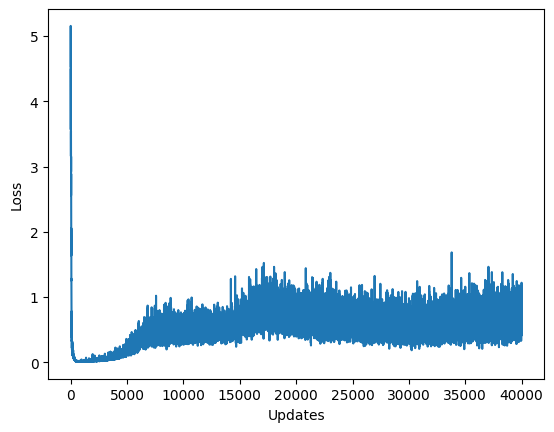

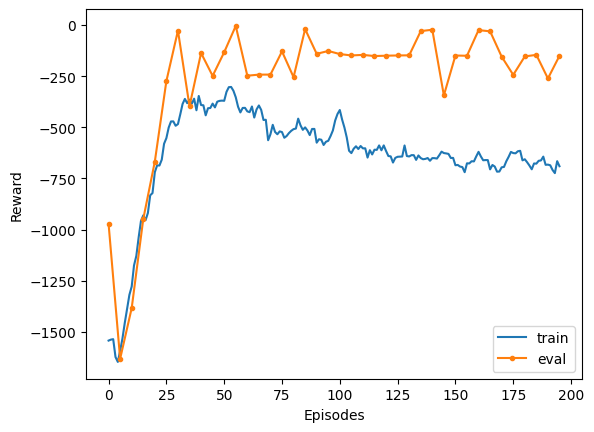

In [38]:
pendulum_env = gym.make("Pendulum-v1")
naf_agent = naf_algo(pendulum_env)

### Continue with the next part of the assignment only when your NAF implementation maintains between 0 and -700 reward on the pendulum environment!
Once the NAF agent reaches acceptable performance on the pendulum environment, explore the effect of exploration noise. In the NAF paper in section 8.2, the authors describe how to use the matrix $P$ from the advantage term for adaptive noise generation. Assuming you used simple Gaussian noise so far, go back to the the forward pass of the neural network and implement adaptive noise instead. Do you observe a considerable difference on the Pendulum environment when using adaptive noise?

# Multigoal environment
Now, we turn to a more interesting but still toy example, the "multigoal" environment introduced in the Soft Q-Learning paper. This environment features four goals (the stars in the below image) the agent can navigate to. The observation is the current position, the actions are 2D velocities to apply to the agent. The agent always starts at the center (plus some small random offset). The reward is the distance to the closest goal plus a small cost proportional to the squarred action sum. Consider below the plot of the reward function evaluated at a fine grid of locations for further intuition:
![multigoal env](notebook_imgs/multigoal-env-reward.png)

# TASK: Draw on a paper a [contour plot](https://se.mathworks.com/help/examples/graphics/win64/DisplayContourLabelsExample_01.png) of what you think NAF's value function will look like, evaluate at 2D locations in the environment as done with the reward function above. Keep the paper for later comparison with the actual value function. 

...

# TASK: Also draw the trajectories that you think NAF's policy will generate. Keep the paper for later comparison with actual trajectories generated by the policy.

...

Presampling done
Total reward train episode 0: -10238.57417909963
Total reward eval episode 0: -10863.991361454997
Total reward train episode 1: -12697.62093690773
Total reward train episode 2: -3516.295220043031
Total reward train episode 3: -3865.032868847169
Total reward train episode 4: -3494.838972809638
Total reward train episode 5: -3624.072450808478
Total reward eval episode 5: -198.47503075896054
Total reward train episode 6: -4254.812022340659
Total reward train episode 7: -3957.8559807563065
Total reward train episode 8: -3785.780157903832
Total reward train episode 9: -3757.162028200701
Total reward train episode 10: -4008.0393143897973
Total reward eval episode 10: -198.00191871036913
Total reward train episode 11: -1001.3496042795631
Total reward train episode 12: -3771.963953854881
Total reward train episode 13: -3951.768689643137
Total reward train episode 14: -3680.7142708773345
Total reward train episode 15: -3700.64563910685
Total reward eval episode 15: -449.1048989

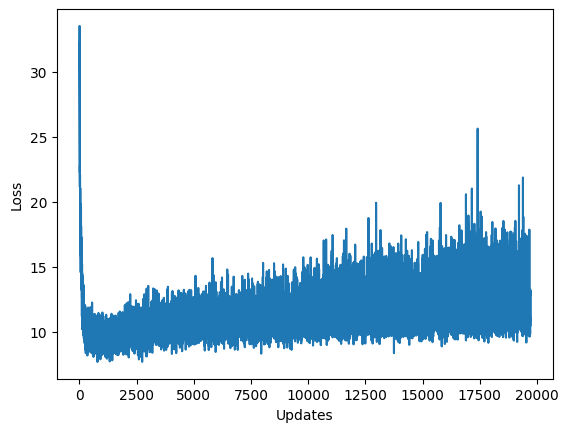

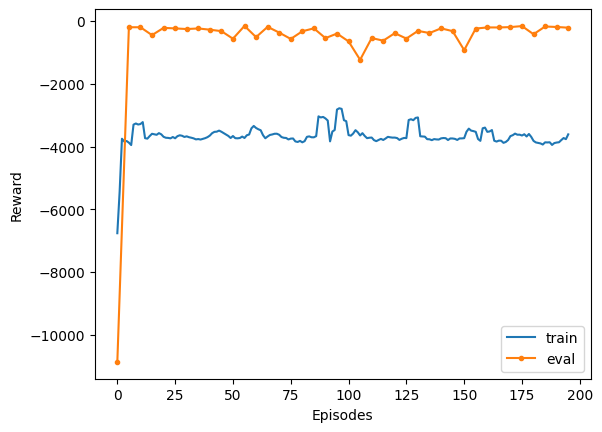

In [18]:
multigoal_env = MultiGoalEnv()
naf_agent = naf_algo(multigoal_env)

# Analyze the reward and loss plots. Explain the result.

...

# Visualizing the value function
In addition to the the loss plot and reward plot above, it can be helpfull to visualize the learned value function and or policy, to understand better what the agent learned. This is often straightforward in 2D environments, since a small 2D grid is still managable in terms of compute. As such, **visualize the value function learned by the NAF agent on the multigoal environment**. Does NAF's learned value function look similar to what you drew on the paper? Can you explain why the learned value function looks the way it does?

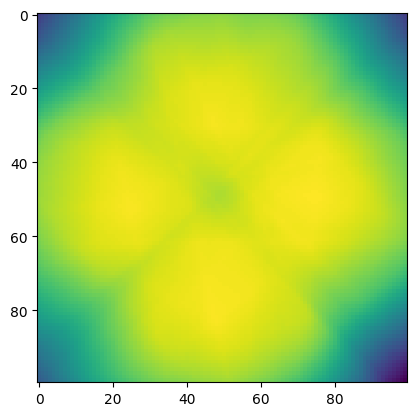

In [19]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt

size = 10
xlist = torch.from_numpy(np.linspace(-size, size, 100))
ylist = torch.from_numpy(np.linspace(-size, size, 100))

img = np.zeros((100,100))

for xi, x in enumerate(xlist):
  for yi, y in enumerate(ylist):
    _, _, v, _ = naf_agent.naf_net(torch.Tensor([x, y]).to(DEVICE))
    img[xi ,yi] = v.item()


plt.imshow(img)

...

# Visualizing trajectories
In addition to the value function, we can inspect the trajectories generated by the policy. **Collect, plot and analyze some (10 - 50) trajectories from the policy**. Are the agent's trajectory similar to what you drew on the paper? Explain the result.

In [20]:
def collect_naf_trajectory(env, agent):
    state_hist = []
    obs, info = env.reset()
    done = False
    truncated = False
    total_reward = 0
    
    while not (done or truncated):
        _, _, _, action = agent.naf_net(torch.from_numpy(obs).to(DEVICE).to(torch.float32))
        action = transform_action(action.squeeze(0), env)
        
        new_obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        
        if done or truncated:
            break
            
        state_hist.append(obs)
        obs = new_obs
    return np.array(state_hist)

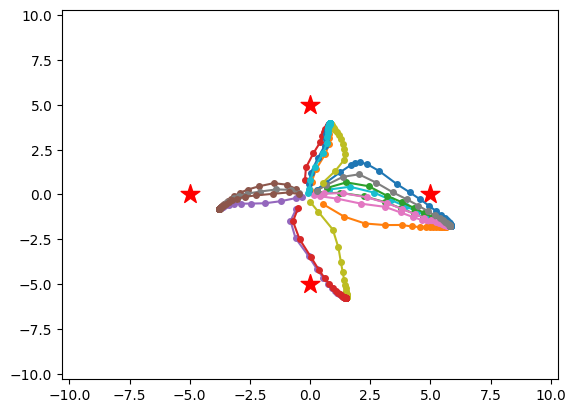

In [28]:
multigoal_env.init_sigma = 0.4  # we increase the reset noise, so we get a bit more diverse starting positions...
for e in range(20):
    obs_hist = collect_naf_trajectory(multigoal_env, naf_agent)
    plt.plot(obs_hist[:,0], obs_hist[:,1], marker="o", markersize=4)
    
for goal in multigoal_env.goal_positions:
    plt.scatter(goal[0], goal[1], marker="*", s=200, c="r")
    
plt.xlim(multigoal_env.xlim + np.array([-0.3,0.3]))
plt.ylim(multigoal_env.ylim + np.array([-0.3,0.3]))
plt.show()
# YOUR CODE HERE

...

# Soft Q-Learning


We now turn to the second algorithm we learned about that can deal with continuous state and action spaces: Soft Q-learning (SQL). SQL is based on two neural networks, one for the $Q$-function and one for the policy. These are plain MLPs, hence this time you don't have to implement the neural network. However, you must initialize these networks with the correct input and output sizes. Thus, **in the `init` method in the next cell, set the `q_in_size`, `q_out_size`, `asvgd_noise_size`, `pi_in_size`, and `pi_out_size` variables**. These are passed to the respective neural networks initalizations.

Further, you will implement the update of the $Q$-function approximating neural network. This is relatively straightforward and based on the TD-error. **In the next cell, in the `td_update` method, calculate the loss for the $Q$-approximating network**. For this, you need to implement and consider the following equations. The soft value function:
![sql_vsoft](notebook_imgs/SQL_v_soft.png)
The soft value function's empirical estimate:
![sql_empirical_vsoft](notebook_imgs/SQL_empirical_v_soft.png)
And the minimization objective:
![sql_JQ](notebook_imgs/SQL_jq.png)
Note, that $\hat{Q}^{\bar\theta}_{\text{soft}} = r_t + \gamma \mathbb{E}_{s_{t+1}\sim p_s}[ V^{\bar\theta}_{\text{soft}}(s_{t+1}) ]$ and that $\bar\theta$ refers to the target network parameter.

We implement the update of the policy network for you, because itrelies on a method not covered in the course, the Amortized Stein Variational Gradient Descent (ASVGD). ASVGD has gained increasing popularity in SOTA research and provides an interesting alternative to sampling methods like Markov Chain Monte Carlo or Metropolis Hastings. ASVGD moves a set of random particles such that, after convergence, they act like samples from the distribution of interest, and only requires access to the unnormalized density. You can take a look how this is implemented and how it updates the policy network in the `asvgd_update` method. If you are interested, we encourage you to take a look at the official [project website](https://www.cs.utexas.edu/~qlearning/project.html?p=svgd).

In [22]:
class SQLAgent:
    """
    SQL agent, https://arxiv.org/pdf/1702.08165.pdf
    """
    def __init__(self,
                 n_states,
                 n_actions,
                 buffer,
                 net_size,
                 gamma,
                 q_lr,
                 asvgd_lr,
                 hard_freq,
                 reward_scale,
                 n_particles,
                 ):
        """
        @param n_states: The dimensionality of the state space
        @param n_actions: The dimensionality of the action space
        @param buffer: An instance of a replay buffer
        @param net_size: The width of the NAF network layers
        @param gamma: The discount rate
        @param q_lr: The learning rate for the q network
        @param asvgd_lr: The learnign rate for the policy network
        @param hard_freq: The hard update frequency of the q target network
        @param reward_scale: The scale of the reward signal
        @param n_particles: The number of particles used by ASVGD
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.buffer = buffer
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.q_update_counter = 0
        self.GAMMA = gamma
        self.HARD_FREQ = hard_freq
        self.loss_hist = []
        self.reward_scale = reward_scale
        self.noise_gen = OUNoise(n_actions)
        self.n_particles = n_particles
        
        #  TODO: set these to the right values (these are all integers...)
        # ---------------------
        q_in_size = n_states + n_actions
        q_out_size = 1
        asvgd_noise_size = n_actions
        pi_in_size = asvgd_noise_size + n_states
        pi_out_size = n_actions
        # ---------------------

        # Q network
        self.q_net = MLP(
            in_size=q_in_size,
            out_size=q_out_size,
            layer_size=net_size,
        ).to(DEVICE)

        # target Q network
        self.target_q_net = MLP(
            in_size=q_in_size,
            out_size=q_out_size,
            layer_size=net_size,
        ).to(DEVICE)
        self.target_q_net.to(DEVICE)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # policy sampling network
        self.pi_net = MLP(
            in_size=pi_in_size,
            out_size=pi_out_size,
            layer_size=net_size,
        ).to(DEVICE)
        self.asvgd_noise_size = asvgd_noise_size

        self.q_optim = Adam(self.q_net.parameters(), lr=q_lr, weight_decay=0.01)
        self.asvgd_optim = Adam(self.pi_net.parameters(), lr=asvgd_lr)

    def td_update(self):
        """
        Updates the Q network based on a batch of experiences drawn uniformly from the replay buffer
        """
        if len(self.buffer.memory) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()
        self.q_optim.zero_grad()

        # predict q for batch
        q = self.q_net.forward(torch.cat((states, actions), dim=1))

        with torch.no_grad():
            # TODO, calculate the 'target' aka 'desired' value J_Q(\theta), so that we can minimize the loss 
            # between q and the target
            # ---------------------
            
            proposal_actions = torch.tensor(
                np.random.uniform(
                    -1,
                    1,
                    size=(next_states.shape[0], self.n_actions)
                )
            ).to(torch.float32).to(DEVICE)
            q_soft = self.target_q_net.forward(torch.cat((next_states, proposal_actions), dim=1))

            v_soft = torch.logsumexp(q_soft, dim=1).unsqueeze(1)

            v_soft += torch.log(torch.tensor([2]).to(DEVICE)) * self.n_actions

            target = self.reward_scale * rewards + self.GAMMA * v_soft * (1-dones)

        loss = self.loss_fn(q, target)
        loss.backward()
        self.q_optim.step()
        self.loss_hist.append(loss.item())

        self.q_update_counter += 1

        # hard target network update
        if self.q_update_counter % self.HARD_FREQ == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
            
    def act(self, state):
        """
        Helper function that constructs the input to the policy network.
        This is done slightly differently depending on on the shape of the state tensor.
        """
        if state.shape[0] == 1:
            # environment interaction
            zeta = torch.rand(self.n_particles, self.asvgd_noise_size).to(DEVICE)
            state = state.repeat(self.n_particles, 1)
            inp = torch.cat((state, zeta), dim=1)
        else:
            # batch update
            zeta = torch.rand(state.shape[0], self.n_particles, self.asvgd_noise_size).to(DEVICE)
            state = state.repeat(self.n_particles, 1, 1).movedim(1, 0)
            inp = torch.cat((state, zeta), dim=2)

        action = self.pi_net.forward(inp.to(torch.float32))

        return action
    
    def rollout(self, env, episode, mode="train"):
        """
        Runs one episode and does a batch update after each step.
        """
        obs, info = env.reset()
        done = False
        truncated = False
        total_reward = 0

        while not (done or truncated):
            a = self.act(torch.from_numpy(obs).unsqueeze(0).to(torch.float32).to(DEVICE))
            o_stack = obs_transform(torch.from_numpy(obs).unsqueeze(0), self.n_particles).to(torch.float32).to(DEVICE)
            q = self.q_net.forward(torch.cat((o_stack, a), dim=1))
            ind = torch.argmax(q)
            action = a[ind]

            if mode == "train":
                action += torch.from_numpy(self.noise_gen.sample()).to(DEVICE)

            action = transform_action(action, env)
            new_obs, reward, done, truncated, info = env.step(action)
            total_reward += reward

            if mode == "train":
                self.buffer.add(obs, action, reward, new_obs, done)
                self.td_update()
                self.asvgd_update()

            if done or truncated:
                print(f"Total reward {mode} episode {episode}: {total_reward}")
                return total_reward

            obs = new_obs

    def asvgd_update(self):
        """
        Updates the policy network using the ASVGD method on a batch of experiences drawn uniformly from the 
        replay buffer.
        """
        if len(self.buffer.memory) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()

        # as described in the appendix of SQL paper, we need two sets of actions
        actions = self.act(states)
        assert actions.shape == (states.shape[0], self.n_particles, self.n_actions)

        fixed_actions = self.act(states)
        fixed_actions = fixed_actions.detach()
        fixed_actions.requires_grad = True

        # target for sampler is q, aka unnormalized policy density, thanks to maximum entropy framework
        state_stack = obs_transform(states, self.n_particles).to(DEVICE)
        asvgd_target = self.q_net(torch.cat((state_stack, fixed_actions), dim=2))
        log_p = asvgd_target

        grad_log_p = torch.autograd.grad(log_p.sum().to(DEVICE), fixed_actions.to(DEVICE))[0]
        grad_log_p = grad_log_p.unsqueeze(1)

        kappa, kappa_grad = rbf_kernel2(actions, fixed_actions)
        
        # eq 13 in paper, stein gradient
        actions_grad = (1/self.n_particles) * torch.sum(kappa * grad_log_p + kappa_grad, dim=1)
        actions_grad.to(DEVICE)

        self.asvgd_optim.zero_grad()
        torch.autograd.backward(-actions, grad_tensors=actions_grad)  # this implements eq 14, chain rule backprop
        self.asvgd_optim.step()

With the update methods taken care of, as before, the only thing that is missing is the main loop. Also as before, we high suggest you don't change any of the hyperparameters until your SQL implementation is working.

In [23]:
def sql_algo(env, reward_scale, n_particles):
    # hyperparameters
    TRAIN_EPISODES = 200
    BATCH_SIZE = 64
    NET_SIZE = 128
    GAMMA = 0.99
    Q_LR = 0.001
    PI_LR = 0.0001
    HARD_FREQ = 1000
    
    buffer = ReplayBuffer(
        buffer_size=int(1e6),
        batch_size=BATCH_SIZE,
        device=DEVICE,
    )
    
    agent = SQLAgent(
        env.observation_space.shape[0],
        env.action_space.shape[0],
        buffer,
        NET_SIZE,
        GAMMA,
        Q_LR,
        PI_LR,
        HARD_FREQ,
        reward_scale,
        n_particles
    )
    
    # populate replay buffer with 10k random transitions
    presample_env(env, agent.buffer, 10000)

    # main loop
    training_rewards = []
    eval_rewards = []
    eval_eps = []
    for episode in range(TRAIN_EPISODES):        
        tr = agent.rollout(env, episode)
        training_rewards.append(tr)

        if episode % 5 == 0:
            er = agent.rollout(env, episode, mode="eval")
            eval_rewards.append(er)
            eval_eps.append(episode)
            
    plot_loss(agent.loss_hist)
    plot_reward(training_rewards, eval_rewards, eval_eps)
    
    return agent

# Testing SQL on Pendulum environment
As before, we first evaluate our implementation on the pendulum environment. The algorithm should be able to reach good performance (between 0 and -700) reward within 100 episodes.

Presampling done
Total reward train episode 0: -959.0918426625863
Total reward eval episode 0: -1738.1408050983805
Total reward train episode 1: -1698.7463573463638
Total reward train episode 2: -1507.4687229622946
Total reward train episode 3: -1571.7993149910153
Total reward train episode 4: -1620.711427979975
Total reward train episode 5: -1361.165244160495
Total reward eval episode 5: -1813.875478627546
Total reward train episode 6: -1668.6289280263356
Total reward train episode 7: -1676.6978230017407
Total reward train episode 8: -1495.673692454569
Total reward train episode 9: -1684.916607291203
Total reward train episode 10: -1440.4155035009778
Total reward eval episode 10: -1697.9291143324554
Total reward train episode 11: -1556.3089655283293
Total reward train episode 12: -1447.0417592604229
Total reward train episode 13: -1575.6117559796928
Total reward train episode 14: -1501.7584353697714
Total reward train episode 15: -1515.0038594593734
Total reward eval episode 15: -1542

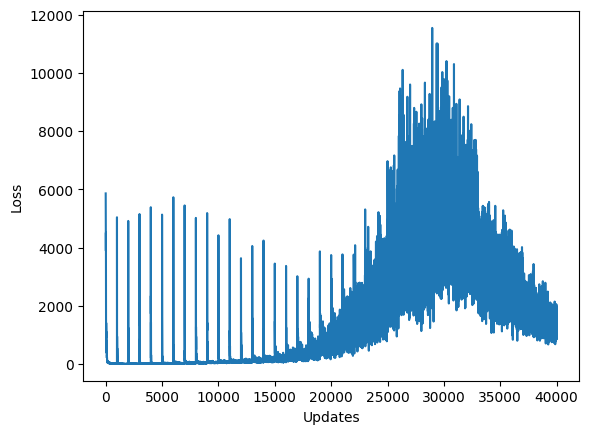

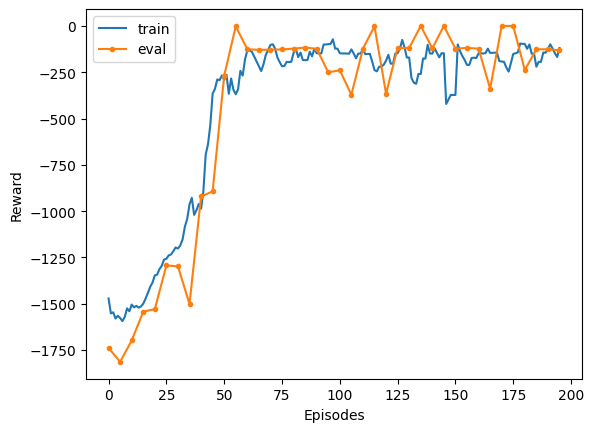

In [24]:
pendulum_env = gym.make("Pendulum-v1")
sql_agent = sql_algo(pendulum_env, reward_scale=10, n_particles=32)

# Testin SQL on Multigoal environment
Once you have verified your SQL implementation, you can continue and test it on the multigoal environment.

## Again, draw what you think the value function learned by SQL will look like. Also draw the trajectories you think SQL will generate.
Again keep the paper for later comparison with the actual results.

Presampling done
Total reward train episode 0: -4287.876812253532
Total reward eval episode 0: -3489.2722356023246
Total reward train episode 1: -4414.016374783478
Total reward train episode 2: -4969.399115414165
Total reward train episode 3: -4098.449555788453
Total reward train episode 4: -2676.1277598399715
Total reward train episode 5: -4868.239925930905
Total reward eval episode 5: -502.4718327776156
Total reward train episode 6: -4453.842876371459
Total reward train episode 7: -2483.096585128111
Total reward train episode 8: -4666.185233842224
Total reward train episode 9: -2910.171663485316
Total reward train episode 10: -2194.4161153709565
Total reward eval episode 10: -1119.5103860719946
Total reward train episode 11: -3698.5279497585097
Total reward train episode 12: -5538.72975410917
Total reward train episode 13: -2898.8311059578523
Total reward train episode 14: -4783.690552438499
Total reward train episode 15: -4288.866086253595
Total reward eval episode 15: -308.50393466

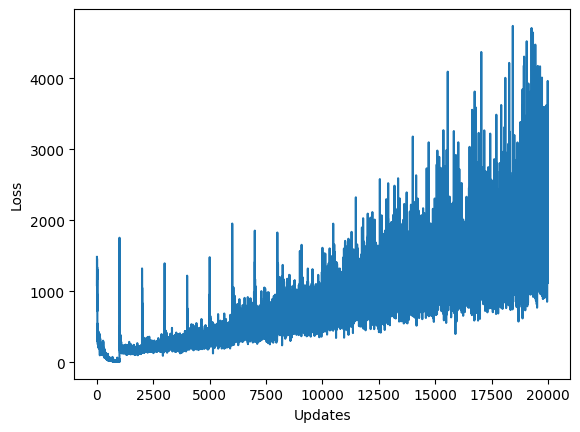

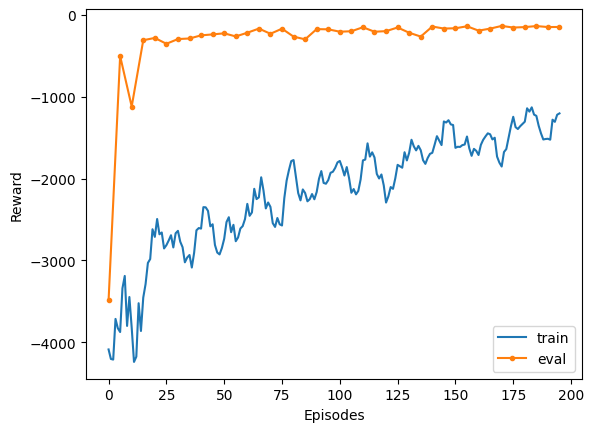

In [25]:
multigoal_env = MultiGoalEnv()
sql_agent = sql_algo(multigoal_env, reward_scale=1, n_particles=100)

### Analyze the plots. Does SQL solve the multigoal environment? 

...

# Visualizing the value function
As before, **visualze the learned value function of the SQL agent**. How does it relate to the reward landscape we saw earlier? How does it compare to the value function learned by NAF? How does it compare to the value function you drew on the paper?

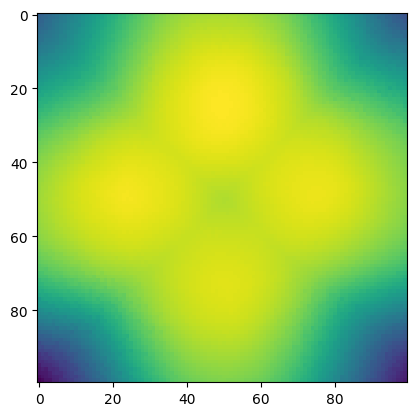

In [59]:
# YOUR CODE HERE
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt

size = 10
xlist = torch.from_numpy(np.linspace(-size, size, 100))
ylist = torch.from_numpy(np.linspace(-size, size, 100))

img = np.zeros((100,100))

for xi, x in enumerate(xlist):
  for yi, y in enumerate(ylist):
    #_, _, v, _ = sql_agent.q_net(torch.Tensor([x, y]).to(DEVICE))
    state = torch.Tensor([x, y]).to(DEVICE)
    states = []
    for i in range(100):
      states.append(state.tolist())
    states = torch.Tensor(states).to(DEVICE)
    proposal_actions = torch.tensor(
      np.random.uniform(
        -1,
        1,
        size=(100, 2)
      )
    ).to(torch.float32).to(DEVICE)
    q_soft = sql_agent.q_net.forward(torch.cat((states, proposal_actions), dim=1))

    v_soft = torch.logsumexp(q_soft, dim=0).unsqueeze(1)

    v_soft += torch.log(torch.tensor([2]).to(DEVICE)) * 2 #self.n_actions
    img[xi ,yi] = v_soft


plt.imshow(img)

# Visualizing the policy
Now, lets also try to **visualize the policy network at interesting points in the environment**. These points coulde be $(0, 0), (\pm 2, 0),$ or $(\pm2.5, \pm2.5)$. Construct the observation manually, feed it into the policy network and visualize the particles. Bonus points if you run KDE on the generated particles ;)
What do you observe? How does the plot of the particles and the KDE explain the shortcomming of the NAF algorithm on the multigoal environment?

In [116]:
from matplotlib.pyplot import imshow
def plot_sql_policy(agent, point):
    particles = sql_agent.act(torch.from_numpy(point.reshape(1,-1)).to(DEVICE)).cpu().detach().numpy()
    kde.gaussian_kde(particles.T)
    
    data = particles
    x = data[:, 0]
    y = data[:, 1]
    xmin, xmax = np.min(particles[:,0]), np.max(particles[:,0])
    ymin, ymax = np.min(particles[:,1]), np.max(particles[:,1])

    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = kde.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # Contourf plot
    cfset = ax.contourf(xx, yy, f, cmap='Blues')
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax.contour(xx, yy, f, colors='k')
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('Y1')
    ax.set_ylabel('Y0')
    plt.scatter(particles[:, 0], particles[:, 1], c="red")

    plt.show()


C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde.gaussian_kde(particles.T)
C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:17: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


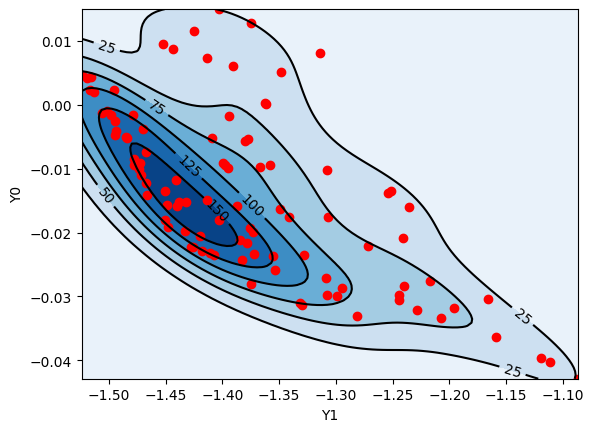

In [117]:
plot_sql_policy(sql_agent, np.array([0,0]))

C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde.gaussian_kde(particles.T)
C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:17: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


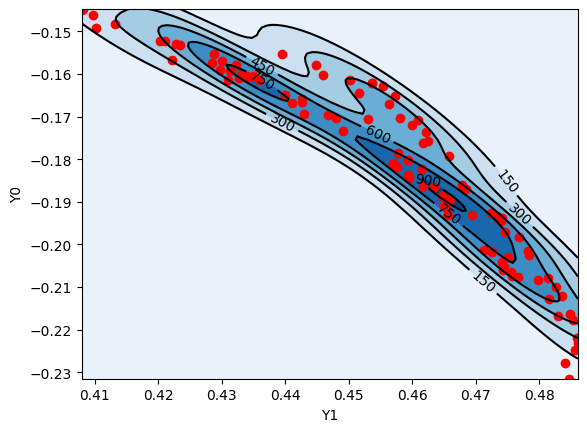

In [120]:
plot_sql_policy(sql_agent, np.array([2,0]))

C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde.gaussian_kde(particles.T)
C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:17: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


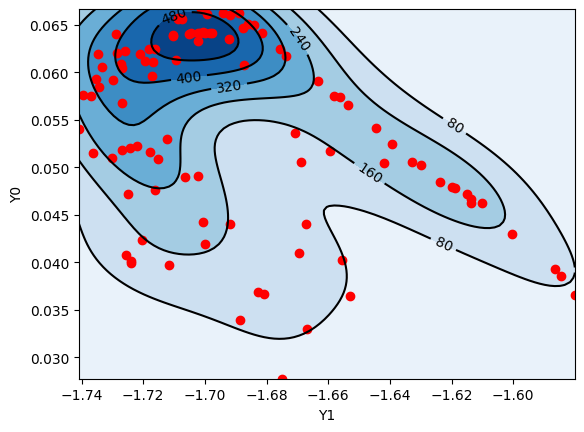

In [123]:
plot_sql_policy(sql_agent, np.array([-2,0]))

C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde.gaussian_kde(particles.T)
C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:17: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


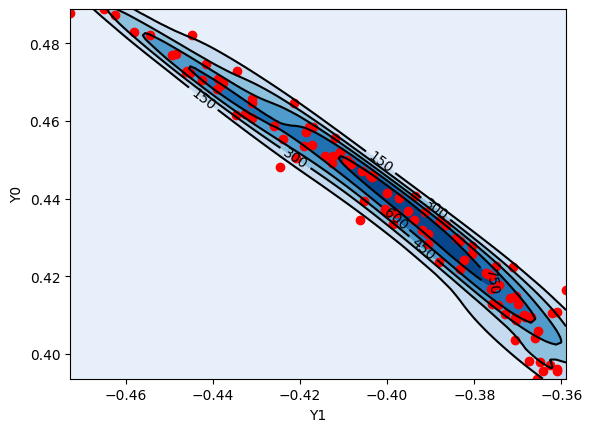

In [124]:
plot_sql_policy(sql_agent, np.array([-2.5,-2.5]))

C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde.gaussian_kde(particles.T)
C:\Users\Linus\AppData\Local\Temp\ipykernel_27584\912480673.py:17: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


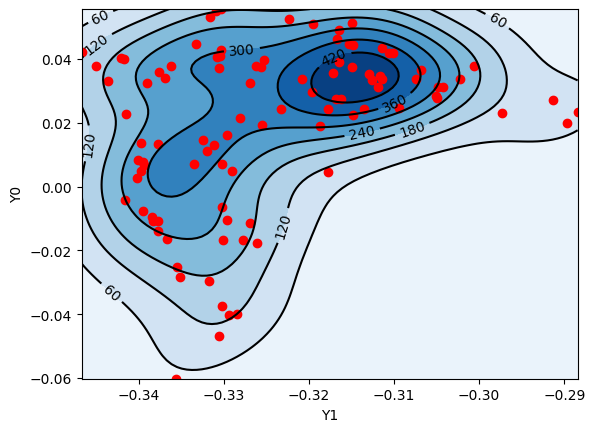

In [128]:
plot_sql_policy(sql_agent, np.array([2.5,2.5]))

...

# Visualizing trajectories
As we did before with NAF, lets explore trajectories taken by the learned SQL policy. **Collect, plot and analyze some (10 - 50) trajectories generated by the SQL agent**. Are the trajectories similar to what you drew on the paper? 

In [131]:
def collect_sql_trajectory(env, agent):
    state_hist = []
    obs, info = env.reset()
    done = False
    truncated = False
    total_reward = 0
    
    while not (done or truncated):
        a = sql_agent.act(torch.from_numpy(obs).unsqueeze(0).to(torch.float32).to(DEVICE))
        o_stack = obs_transform(torch.from_numpy(obs).unsqueeze(0), sql_agent.n_particles).to(torch.float32).to(DEVICE)
        q = sql_agent.q_net.forward(torch.cat((o_stack, a), dim=1))
        ind = torch.argmax(q)
        action = a[ind]

        action = transform_action(action, env)
        new_obs, reward, done, truncated, info = env.step(action)
        total_reward += reward

        if done or truncated:
            break
        state_hist.append(obs)
        obs = new_obs
    return np.array(state_hist)

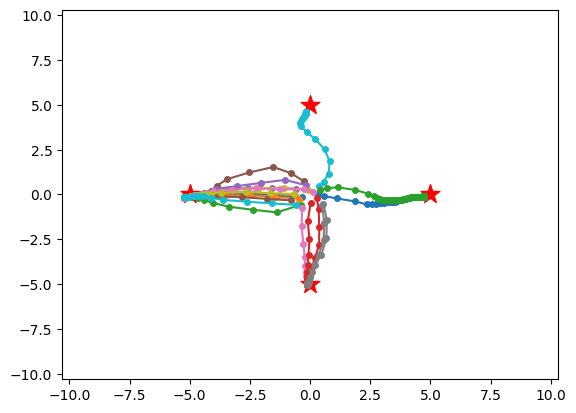

In [135]:
multigoal_env.init_sigma = 0.4  # we increase the reset noise, so we get a bit more diverse starting positions...
for e in range(20):
    obs_hist = collect_sql_trajectory(multigoal_env, naf_agent)
    plt.plot(obs_hist[:,0], obs_hist[:,1], marker="o", markersize=4)
    
for goal in multigoal_env.goal_positions:
    plt.scatter(goal[0], goal[1], marker="*", s=200, c="r")
    
plt.xlim(multigoal_env.xlim + np.array([-0.3,0.3]))
plt.ylim(multigoal_env.ylim + np.array([-0.3,0.3]))
plt.show()

...

# Optional tasks:
If you are done with everything and there is time left, we encourage you to do some (or all) of the following tasks:
+ Play with hyperparameters: For SQL, particularly interesting might be the reward scale, the number of particles used by the policy network with ASVGD, and the learning rates `Q_LR` and `PI_LR` (they might have an unespected relationship).
+ Generally, varying the batch size, the network size, the loss functions, and the optimizers target update rate `TAU` or hard update frequncy `HARD_FREQ` can have intersting effects. A poor value can often render the RL algorithm completely incapable of learning a task, while a good value can speed up and stabilize training considerably. Try varying those parameters and note the effects.
+ You can implement different explortation mechanisms. For example, the SQL implementation uses OU noise, which is a a form of temporally correlated noise and a rather powerful mechanism. How does SQL perform with, for example, epsilon greedy or Gaussian noise? In the same way, perhaps NAF can be improved by using OU noise instead of Gaussian or adaptive noise?
+ Lastly, given the somewhat complex ASVGD update mechanism in the SQL policy update, you can implement a simpler method like Metropolis Hastings or Hamiltonian Monte Carlo to sample from the policy.